<a href="https://colab.research.google.com/github/rca-devs/CIS-5450/blob/main/CIS_5450_course_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://esap.seas.upenn.edu/wp-content/themes/summer_engineering/media/seas_logo.png)

#Introduction

Welcome to our course project for CIS-5450 (Big Data Analytics)!

Our team consists of:

*   Ryan Abbate (MSE-DS, inaugural cohort)
*   Paul Hamel (MCIT, Spring 2022 cohort)
*   Milan Mistry (MCIT, Fall 2021 cohort)

<br>
For this project, we built machine learning models that predict a borrower's propensity to default on a loan. Throughout this notebook, we walk through our end-to-end process, which included:

* data ingestion
* exploratory data analysis (EDA)
* data wrangling
* data cleaning
* machine learning modeling
* data visualization


# Motivation

Individuals with insufficient or non-existent credit histories often encounter challenges in securing loans.  Those fortunate enough to obtain loans may fall victim to unscrupulous lenders who impose exorbitant interest rates and unfavorable lending terms.

Lenders generally aim to optimize profits while minimizing potential risks.  Lenders that use *accurate* predictive models when assessing default risk among certain customer profiles are able to extend credit to borrowers who may not meet traditional lending standards.  This data-driven approach ensures that borrowers who are capable of loan repayment receive the capital that they need, which has a stimulative effect on economic activity.


# Data Source

For this project, we used loan repayment data from a Kaggle competition hosted by [Home Credit Group](https://www.homecredit.net/) in 2018.  Details about the competition may be found [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The data consists of nine (9) csv files totaling approximately 3GB in size.  

# Data Ingestion

To retrieve and ingest the data from Kaggle's public API, users must authenticate with an API token.  To create an API token, please follow the instructions outlined [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The API token will be in the form of a JSON file named `kaggle.json`.  

#Dependencies

Let's begin by installing the required dependencies.


In [1]:
# install dependencies with silenced output
!pip install kaggle --quiet
!pip install tqdm --quiet

Next, we import the Python libraries that we'll use for this project.

In [2]:
# import required libraries
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm


Run the cell below, then click "Choose Files".  Browse to the `kaggle.json` file, then select this file for upload.

In [3]:
# upload your Kaggle API key to download the data
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryanabbate","key":"09d24706541b17b088d1497a650c71d8"}'}

Next, we'll create a Kaggle directory and copy the file containing our API token into the newly created directory.

In [4]:
# create the Kaggle directory
!mkdir ~/.kaggle

# copy the file containing API key to newly created directory and change file permissions
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

We'll now download the dataset in the form of a zip file.

In [5]:
# download the dataset
!!kaggle competitions download -c home-credit-default-risk

['Downloading home-credit-default-risk.zip to /content',
 '',
 '  0% 0.00/688M [00:00<?, ?B/s]',
 '  1% 5.00M/688M [00:00<00:24, 29.5MB/s]',
 '  4% 30.0M/688M [00:00<00:05, 132MB/s] ',
 '  7% 46.0M/688M [00:00<00:12, 54.7MB/s]',
 ' 10% 71.0M/688M [00:00<00:07, 90.0MB/s]',
 ' 13% 89.0M/688M [00:01<00:06, 104MB/s] ',
 ' 16% 110M/688M [00:01<00:04, 127MB/s] ',
 ' 18% 127M/688M [00:01<00:08, 66.1MB/s]',
 ' 22% 151M/688M [00:01<00:06, 90.3MB/s]',
 ' 24% 167M/688M [00:02<00:06, 84.6MB/s]',
 ' 27% 185M/688M [00:02<00:05, 99.4MB/s]',
 ' 30% 209M/688M [00:02<00:04, 112MB/s] ',
 ' 34% 232M/688M [00:02<00:03, 135MB/s]',
 ' 37% 253M/688M [00:02<00:02, 153MB/s]',
 ' 40% 273M/688M [00:02<00:02, 164MB/s]',
 ' 43% 297M/688M [00:02<00:02, 159MB/s]',
 ' 46% 315M/688M [00:02<00:02, 165MB/s]',
 ' 48% 333M/688M [00:04<00:07, 49.1MB/s]',
 ' 51% 354M/688M [00:04<00:05, 64.5MB/s]',
 ' 54% 369M/688M [00:04<00:04, 73.2MB/s]',
 ' 56% 383M/688M [00:04<00:03, 82.7MB/s]',
 ' 58% 397M/688M [00:04<00:03, 81.6MB/s]',


After downloading the dataset, we'll unzip the file into our `Content` directory.

In [6]:
# unzip the zip file into the Content directory
!unzip /content/home-credit-default-risk.zip

Archive:  /content/home-credit-default-risk.zip
  inflating: HomeCredit_columns_description.csv  
  inflating: POS_CASH_balance.csv    
  inflating: application_test.csv    
  inflating: application_train.csv   
  inflating: bureau.csv              
  inflating: bureau_balance.csv      
  inflating: credit_card_balance.csv  
  inflating: installments_payments.csv  
  inflating: previous_application.csv  
  inflating: sample_submission.csv   


Now, we'll identify the files that we'll use during our analysis and exclude those that are irrelevant.

In [7]:
# the list of files to exclude from relevant data files
excluded_files = ['kaggle.json', 'home-credit-default-risk.zip', '.config', 'sample_data', 'sample_submission.csv', 'HomeCredit_columns_description.csv']

# create a list of relevant data files
data_files = [data_file for data_file in os.listdir('/content') if data_file not in excluded_files]
data_files


['bureau_balance.csv',
 'credit_card_balance.csv',
 'previous_application.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'application_train.csv',
 'application_test.csv',
 'bureau.csv']

After identifying the relevant eight (8) data files, we'll create a Pandas dataframe for each.  Notice that we create an empty dictionary `d`, then iterate through the list of relevant file and append `_df` to the file name when assigning the name of the dataframe.  We use the popular `tqdm` library to monitor progress as the dataframes are being created.

In [8]:
# iterate over list of relevant data files and create a Pandas dataframe for each

d = {}

for data_file in tqdm(data_files):
  print('Creating:', data_file.removesuffix('.csv') + '_df')
  d[(data_file.removesuffix('.csv') + '_df').lower()] = pd.read_csv(data_file)


  0%|          | 0/8 [00:00<?, ?it/s]

Creating: bureau_balance_df
Creating: credit_card_balance_df
Creating: previous_application_df
Creating: installments_payments_df
Creating: POS_CASH_balance_df
Creating: application_train_df
Creating: application_test_df
Creating: bureau_df


In [4]:
# For Paul when running locally -- ignore this
# d = {}
# d['application_test_df'] = pd.read_csv('./data/application_test.csv', encoding='latin-1')
# d['application_train_df'] = pd.read_csv('./data/application_train.csv', encoding='latin-1')
# d['bureau_df'] = pd.read_csv('./data/bureau.csv', encoding='latin-1')
# d['bureau_balance_df'] = pd.read_csv('./data/bureau_balance.csv', encoding='latin-1')
# d['credit_card_balance_df'] = pd.read_csv('./data/credit_card_balance.csv', encoding='latin-1')
# d['installments_payments_df'] = pd.read_csv('./data/installments_payments.csv', encoding='latin-1')
# d['pos_cash_balance_df'] = pd.read_csv('./data/POS_CASH_balance.csv', encoding='latin-1')
# d['previous_application_df'] = pd.read_csv('./data/previous_application.csv', encoding='latin-1')

Since we stored the dataframes in a dictionary `d`, we access a given dataframe by its key.  Let's inspect the data.

In [5]:
# access dataframes via a dictionary such as d['bureau_df']
d['bureau_df'].head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [6]:
# inspect all dataframes
for key, df in d.items():
  print(key)
  print('\n')
  print(df.head())
  print('\n')


application_test_df


   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19

In [7]:
# cast all column headers to lowercase
for key, df in d.items():
  df.columns = df.columns.str.lower()


#Exploratory Data Analysis (EDA)

We start by exploring the basic characteristics of the dataset.  On each dataframe, we call the `info()` method to display the data type and non-null counts.  We call the `describe()` method to display the summary statistics.

In [8]:
for key, df in d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

application_test_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    sk_id_curr                    48744 non-null  int64  
 1    name_contract_type            48744 non-null  object 
 2    code_gender                   48744 non-null  object 
 3    flag_own_car                  48744 non-null  object 
 4    flag_own_realty               48744 non-null  object 
 5    cnt_children                  48744 non-null  int64  
 6    amt_income_total              48744 non-null  float64
 7    amt_credit                    48744 non-null  float64
 8    amt_annuity                   48720 non-null  float64
 9    amt_goods_price               48744 non-null  float64
 10   name_type_suite               47833 non-null  object 
 11   name_income_type              48744 non-null  object 
 12   name_education_type     

We notice the prevalance of the `sk_id_curr` attribute, which is the primary key of the `application_{test | train}_df` relations.  The following relations have `sk_id_curr` as a foreign key:

*   `bureau_df`
*   `pos_cash_balance_df`
*   `previous_application_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

We will join the `application_{test | train}_df` relations to each of the five (5) above-mentioned relations.

We also notice the prevalance of the `sk_id_prev` attribute, which is the primary key of the `previous_application_df` relation.  The following relations have `sk_id_prev` as a foreign key:

*   `pos_cash_balance_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

Lastly, we notice that the `sk_id_bureau` attribute is the primary key of the `bureau_df` relation.  The `bureau_balance_df` relation has `sk_id_bureau` as a foreign key.  We will therefore join these two relations together.


First, we explore what % of the unique `sk_id_prev` IDs are within each dataset. We see that most of the datasets have a high representation of the IDs present. The two datasets with low representation are the `bureau_balance_df` and the `credit_card_balance_df` dataframes. We will later explore whether adding features from these two datasets are better when having a dummy variable for whether each feature is valid, or whether multiple models depending on the availability of data is more suitable for this dataset.

In [22]:
train_ids = d['application_train_df']['sk_id_curr'].unique()

#Bureau 
bureau_pct = len(np.intersect1d(d['bureau_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Bureau: {:.2%}'.format(bureau_pct))

#Bureau Balance
valid_bureau_ids = np.intersect1d(d['bureau_balance_df']['sk_id_bureau'].unique(), d['bureau_df']['sk_id_bureau'].unique())
buearu_balance_pct = len(np.intersect1d(d['bureau_df'].loc[d['bureau_df']['sk_id_bureau'].isin(valid_bureau_ids),'sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Bureau Balance: {:.2%}'.format(buearu_balance_pct))

#Credit Card Balance
cc_pct = len(np.intersect1d(d['credit_card_balance_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Credit Card Balance: {:.2%}'.format(cc_pct))

#Previous Application
prev_app_pct = len(np.intersect1d(d['previous_application_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Previous Application: {:.2%}'.format(prev_app_pct))

#POS Cash Balance
pos_cash_pct = len(np.intersect1d(d['pos_cash_balance_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('POS Cash Balance: {:.2%}'.format(pos_cash_pct))

#Installments Payments
installments_pct = len(np.intersect1d(d['installments_payments_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Installments Payments: {:.2%}'.format(installments_pct))

Bureau: 85.69%
Bureau Balance: 29.99%
Credit Card Balance: 28.26%
Previous Application: 94.65%
POS Cash Balance: 94.12%
Installments Payments: 94.84%


In [13]:
# join the base relation `application_train_df` to each of the relations with foreign keys

#application_train_merged = d['application_train_df'].merge(d['POS_CASH_balance_df'], on = 'sk_id_curr')
#                                                    .merge(d['previous_application_df'], on = 'sk_id_curr') \
#                                                    .merge(d['installments_payments_df'], on = 'sk_id_curr') \
#                                                    .merge(d['credit_card_balance_df'], on = 'sk_id_curr')
#                                                    .merge(d['bureau_df'], on = 'sk_id_curr')

#application_train_merged.head()

Let's check for duplication.

In [9]:
for key, df in d.items():
  print('Dataframe:', key)
  print(df.nunique())
  print('-' * 72)

Dataframe: application_test_df
sk_id_curr                    48744
name_contract_type                2
code_gender                       2
flag_own_car                      2
flag_own_realty                   2
                              ...  
amt_req_credit_bureau_day         3
amt_req_credit_bureau_week        3
amt_req_credit_bureau_mon         7
amt_req_credit_bureau_qrt         8
amt_req_credit_bureau_year       16
Length: 121, dtype: int64
------------------------------------------------------------------------
Dataframe: application_train_df
sk_id_curr                    307511
target                             2
name_contract_type                 2
code_gender                        3
flag_own_car                       2
                               ...  
amt_req_credit_bureau_day          9
amt_req_credit_bureau_week         9
amt_req_credit_bureau_mon         24
amt_req_credit_bureau_qrt         11
amt_req_credit_bureau_year        25
Length: 122, dtype: int64
---------

The data contains a significant number of `null` values.  Let's drop these instances!

In [15]:
# create a dictionary `cleaned_d` to store the clean dataframes
cleaned_d = {}

for key, df in d.items():
  print('Removing any missing values in:', key)
  cleaned_d[key] = df.dropna(how = 'any')


Removing any missing values in: bureau_balance_df
Removing any missing values in: credit_card_balance_df
Removing any missing values in: previous_application_df
Removing any missing values in: installments_payments_df
Removing any missing values in: POS_CASH_balance_df
Removing any missing values in: application_train_df
Removing any missing values in: application_test_df
Removing any missing values in: bureau_df


Now, the `cleaned_d` dictionary contains the cleaned dataframes. Let's reinspect the data to ensure there are no missing values.

In [16]:
for key, df in cleaned_d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

bureau_balance_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   sk_id_bureau    27299925 non-null  int64 
 1   months_balance  27299925 non-null  int64 
 2   status          27299925 non-null  object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
------------------------------------------------------------------------
credit_card_balance_df
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3014276 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   sk_id_prev                  3014276 non-null  int64  
 1   sk_id_curr                  3014276 non-null  int64  
 2   months_balance              3014276 non-null  int64  
 3   amt_balance                 3014276 non-null  float64
 4   amt_credit_li

In [17]:
for key, df in d.items():
  print(key)
  print(df.describe(include = np.number).T)
  print('-' * 72)

bureau_balance_df
                     count          mean            std        min        25%  \
sk_id_bureau    27299925.0  6.036297e+06  492348.856904  5001709.0  5730933.0   
months_balance  27299925.0 -3.074169e+01      23.864509      -96.0      -46.0   

                      50%        75%        max  
sk_id_bureau    6070821.0  6431951.0  6842888.0  
months_balance      -25.0      -11.0        0.0  
------------------------------------------------------------------------
credit_card_balance_df
                                count          mean            std  \
sk_id_prev                  3840312.0  1.904504e+06  536469.470563   
sk_id_curr                  3840312.0  2.783242e+05  102704.475133   
months_balance              3840312.0 -3.452192e+01      26.667751   
amt_balance                 3840312.0  5.830016e+04  106307.031024   
amt_credit_limit_actual     3840312.0  1.538080e+05  165145.699525   
amt_drawings_atm_current    3090496.0  5.961325e+03   28225.688578   
am

#Correlation Analysis
Now, we'll generate a correlation matrix on the training dataset to check for correlation among the features.

In [18]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

corr = d['application_train_df'].corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm').format(precision = 2)


Given the size of this correlation matrix, let's set a threshold and view only the features that have correlation greater than a certain threshold.

In [19]:
# define a threshold
correlation_threshold = 0.7

# get a list of features that exceed this threshold
high_correlation_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append((corr.columns[i], corr.columns[j]))


high_correlation_pairs


[('cnt_children', 'cnt_fam_members'),
 ('amt_credit', 'amt_annuity'),
 ('amt_credit', 'amt_goods_price'),
 ('amt_annuity', 'amt_goods_price'),
 ('days_employed', 'flag_emp_phone'),
 ('region_rating_client', 'region_rating_client_w_city'),
 ('reg_region_not_work_region', 'live_region_not_work_region'),
 ('reg_city_not_work_city', 'live_city_not_work_city'),
 ('apartments_avg', 'elevators_avg'),
 ('apartments_avg', 'livingapartments_avg'),
 ('apartments_avg', 'livingarea_avg'),
 ('apartments_avg', 'apartments_mode'),
 ('apartments_avg', 'elevators_mode'),
 ('apartments_avg', 'livingapartments_mode'),
 ('apartments_avg', 'livingarea_mode'),
 ('apartments_avg', 'apartments_medi'),
 ('apartments_avg', 'elevators_medi'),
 ('apartments_avg', 'livingapartments_medi'),
 ('apartments_avg', 'livingarea_medi'),
 ('apartments_avg', 'totalarea_mode'),
 ('basementarea_avg', 'basementarea_mode'),
 ('basementarea_avg', 'basementarea_medi'),
 ('years_beginexpluatation_avg', 'years_beginexpluatation_mode

In [20]:
print(f'There are {len(high_correlation_pairs)} that exhibit correlation greater than {correlation_threshold}.')

There are 127 that exhibit correlation greater than 0.7.


In [21]:
# create a heatmap of only the high correlation pairs

high_correlation_features = set()

for pair in high_correlation_pairs:
  high_correlation_features.update(pair)

high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]
high_correlation_matrix

high_correlation_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)




<ipython-input-21-74dee6ea2dba>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]


,years_beginexpluatation_avg,amt_annuity,cnt_fam_members,entrances_medi,apartments_mode,elevators_avg,nonlivingarea_medi,def_30_cnt_social_circle,years_beginexpluatation_mode,live_region_not_work_region,obs_60_cnt_social_circle,livingapartments_medi,landarea_avg,elevators_mode,live_city_not_work_city,years_beginexpluatation_medi,floorsmin_medi,floorsmax_mode,entrances_mode,landarea_medi,def_60_cnt_social_circle,livingarea_avg,days_employed,basementarea_medi,reg_region_not_work_region,years_build_mode,floorsmax_avg,reg_city_not_work_city,region_rating_client_w_city,years_build_medi,amt_credit,livingapartments_mode,totalarea_mode,commonarea_avg,elevators_medi,floorsmin_avg,obs_30_cnt_social_circle,commonarea_medi,nonlivingapartments_avg,region_rating_client,nonlivingapartments_mode,entrances_avg,basementarea_mode,nonlivingapartments_medi,flag_emp_phone,livingapartments_avg,amt_goods_price,livingarea_mode,livingarea_medi,nonlivingarea_mode,apartments_medi,years_build_avg,commonarea_mode,floorsmin_mode,floorsmax_medi,landarea_mode,apartments_avg,nonlivingarea_avg,cnt_children,basementarea_avg
years_beginexpluatation_avg,1.00,0.01,0.01,0.04,0.10,0.08,0.01,-0.01,0.97,0.01,-0.00,0.15,0.07,0.08,-0.01,0.99,0.17,0.13,0.04,0.07,-0.00,0.09,0.01,0.09,0.01,0.48,0.13,-0.02,-0.00,0.48,0.01,0.14,0.10,0.09,0.08,0.17,-0.00,0.09,0.03,0.00,0.03,0.04,0.08,0.03,-0.01,0.15,0.01,0.09,0.09,0.01,0.10,0.48,0.09,0.16,0.13,0.07,0.10,0.01,0.01,0.09
amt_annuity,0.01,1.00,0.08,0.01,0.07,0.10,0.05,-0.02,0.01,0.07,-0.01,0.07,0.01,0.09,0.01,0.01,0.10,0.13,0.01,0.01,-0.02,0.09,-0.10,0.04,0.08,0.03,0.13,0.00,-0.14,0.03,0.77,0.07,0.09,0.06,0.10,0.10,-0.01,0.06,0.02,-0.13,0.02,0.01,0.03,0.02,0.10,0.08,0.78,0.08,0.09,0.04,0.07,0.03,0.05,0.09,0.13,0.00,0.08,0.05,0.02,0.04
cnt_fam_members,0.01,0.08,1.00,-0.00,-0.01,-0.00,0.00,-0.00,0.01,0.01,0.02,-0.01,0.00,0.00,0.08,0.01,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.23,-0.00,0.00,0.04,-0.00,0.07,0.03,0.04,0.06,-0.01,-0.00,0.00,-0.00,-0.00,0.03,0.00,0.00,0.03,0.00,-0.00,-0.00,0.00,0.23,-0.01,0.06,-0.00,-0.00,0.00,-0.01,0.04,0.00,0.00,-0.00,0.00,-0.01,0.00,0.88,-0.00
entrances_medi,0.04,0.01,-0.00,1.00,0.61,0.40,0.17,-0.00,0.04,-0.01,-0.00,0.57,0.51,0.40,-0.04,0.04,0.03,0.09,0.98,0.51,-0.01,0.62,0.00,0.65,-0.01,0.09,0.08,-0.04,-0.03,0.09,0.01,0.57,0.59,0.32,0.40,0.03,-0.00,0.33,0.06,-0.02,0.06,1.00,0.65,0.06,-0.00,0.56,0.02,0.62,0.62,0.17,0.61,0.09,0.33,0.04,0.08,0.51,0.61,0.16,-0.01,0.65
apartments_mode,0.10,0.07,-0.01,0.61,1.00,0.81,0.29,-0.01,0.10,0.02,-0.02,0.91,0.50,0.83,-0.07,0.10,0.42,0.60,0.62,0.50,-0.02,0.89,-0.01,0.67,0.01,0.33,0.59,-0.09,-0.14,0.32,0.05,0.94,0.86,0.52,0.81,0.42,-0.02,0.52,0.18,-0.12,0.18,0.61,0.68,0.18,0.01,0.91,0.06,0.91,0.89,0.29,0.98,0.32,0.53,0.42,0.59,0.51,0.97,0.29,-0.01,0.67
elevators_avg,0.08,0.10,-0.00,0.40,0.81,1.00,0.28,-0.02,0.07,0.03,-0.03,0.81,0.38,0.98,-0.07,0.08,0.51,0.67,0.38,0.38,-0.02,0.87,-0.01,0.56,0.02,0.34,0.68,-0.08,-0.24,0.34,0.08,0.80,0.84,0.52,1.00,0.51,-0.03,0.52,0.12,-0.23,0.11,0.41,0.54,0.12,0.01,0.81,0.08,0.84,0.87,0.26,0.83,0.34,0.51,0.50,0.68,0.36,0.84,0.28,-0.01,0.56
nonlivingarea_medi,0.01,0.05,0.00,0.17,0.29,0.28,1.00,-0.01,-0.01,0.02,-0.01,0.29,0.16,0.28,-0.01,0.01,0.15,0.24,0.16,0.17,-0.01,0.30,-0.01,0.27,0.01,0.12,0.25,-0.02,-0.07,0.13,0.04,0.29,0.36,0.23,0.28,0.15,-0.01,0.23,0.22,-0.07,0.21,0.17,0.26,0.22,0.01,0.29,0.04,0.29,0.30,0.98,0.30,0.12,0.22,0.14,0.25,0.16,0.30,0.99,0.00,0.27
def_30_cnt_social_circle,-0.01,-0.02,-0.00,-0.00,-0.01,-0.02,-0.01,1.00,-0.00,-0.02,0.33,-0.01,-0.00,-0.02,-0.00,-0.01,-0.02,-0.03,-0.00,-0.00,0.86,-0.02,0.02,-0.01,-0.02,-0.01,-0.03,0.00,0.01,-0.01,-0.02,-0.01,-0.02,-0.01,-0.02,-0.02,0.33,-0.01,0.00,0.02,0.01,-0.00,-0.01,0.00,-0.02,-0.01,-0.02,-0.01,-0.02,-0.01,-0.01,-0.01,-0.01,-0.02,-0.03,-0.00,-0.01,-0.01,-0.00,-0.01
years_beginexpluatation_mode,0.97,0.01,0.01,0.04,0.10,0.07,-0.01,-0.00,1.00,0.01,-0.00,0.08,0.05,0.08,-0.01,0.96,0.10,0.11,0.04,0.05,-0.00,0.08,0.01,0.06,0.01,0.29,0.10,-0.01,-0.00,0.29,0.00,0.08,0.10,0.05,0.07,0.1

Let's look at a pairplot.

In [22]:
#
#df = d['application_train_df']
#df = df[list(high_correlation_features)]
#df.head()

In [23]:
#sns.pairplot(data = df)

Now, let's plot the distribution of the categorical variables using `sns.countplot()`.

In [24]:
object_columns = d['application_train_df'].select_dtypes(include=['object']).columns.tolist()
object_columns

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

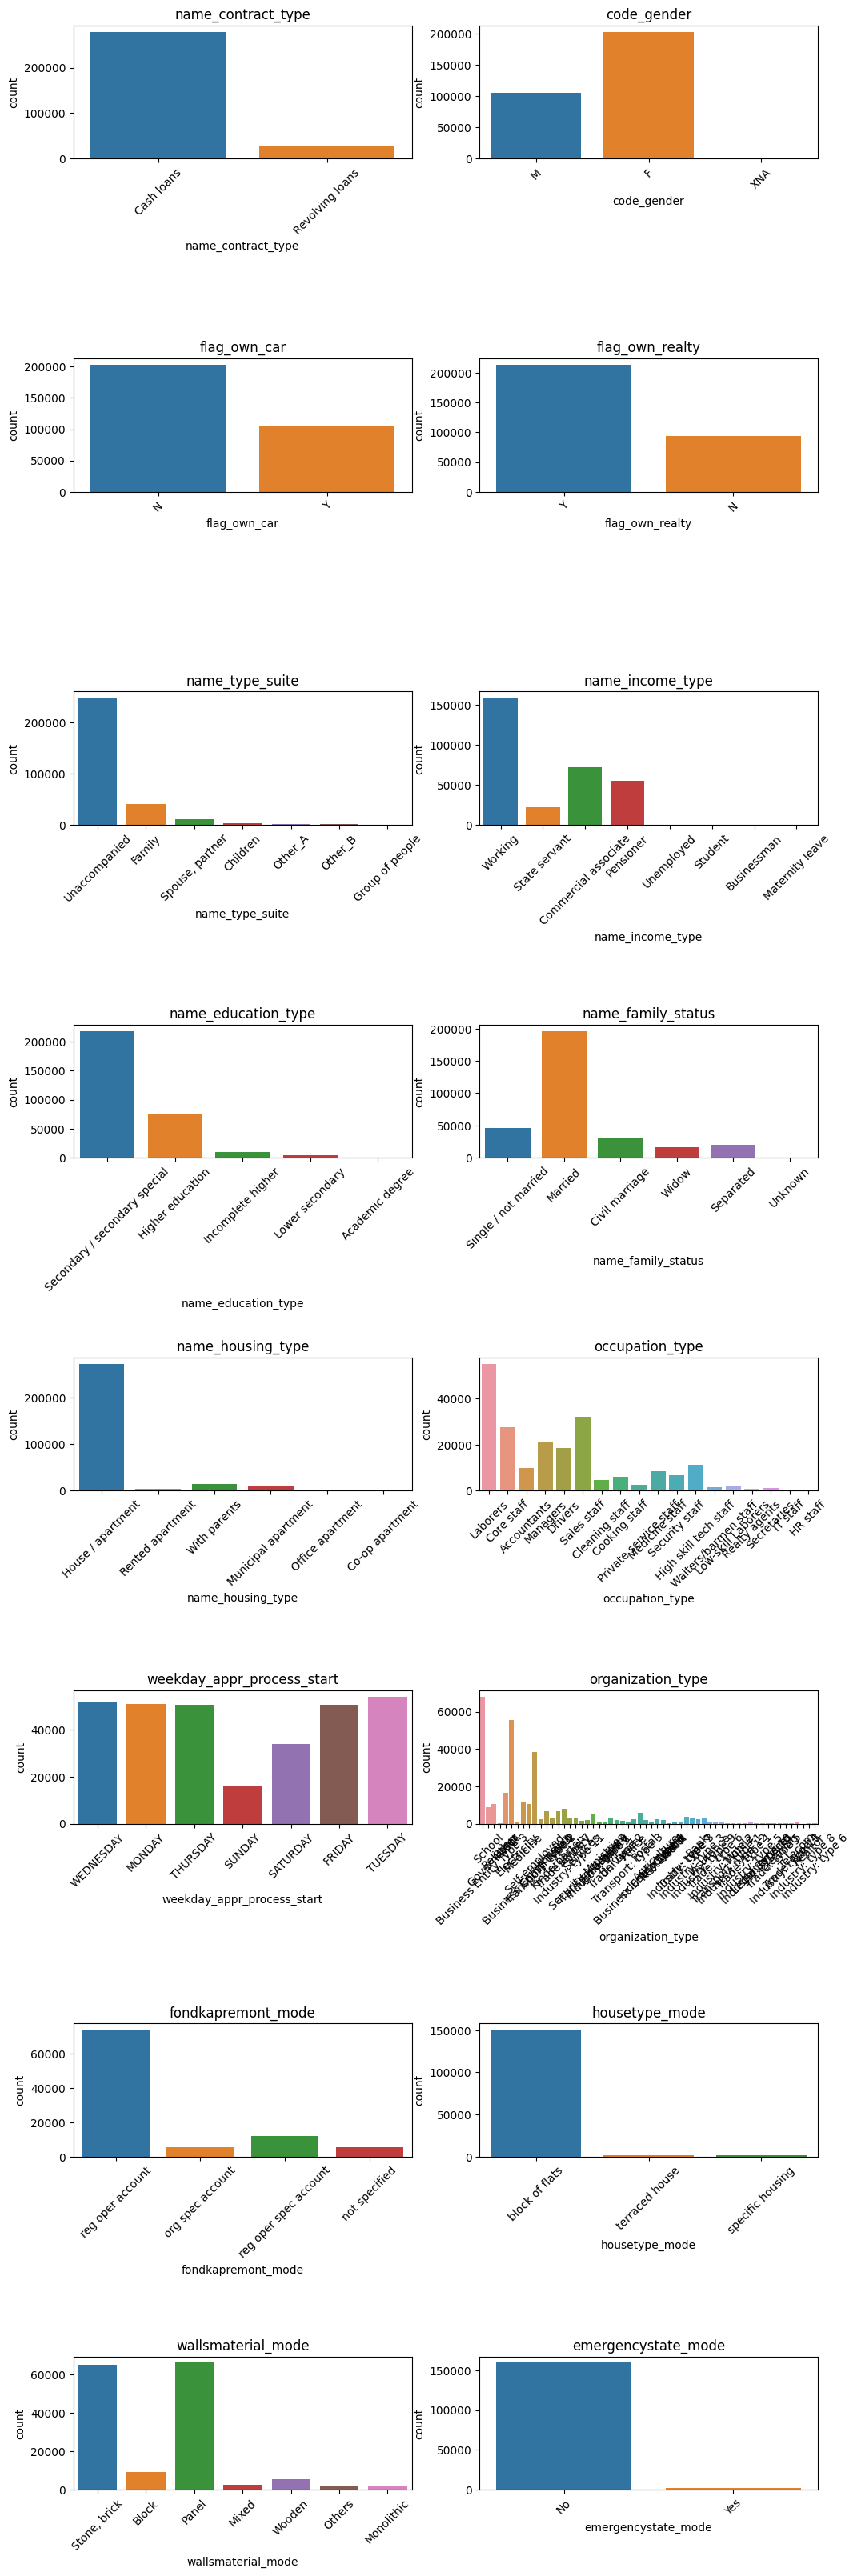

In [25]:
# plot these

# define height ratios for the subplots
height_ratios = [50] * 7 + [50]

# create a 4x4 subplot grid
fig, axes = plt.subplots(8, 2, figsize=(12, 40), gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace = 1.5)

# flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(object_columns):
    sns.countplot(x = column, data = d['application_train_df'], ax = axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

#plt.tight_layout(h_pad = 2.5)
plt.show()

In [37]:
# initial impressions
# predominent:  married females with a secondary education who own a home (but don't own a car) applying for cash loans

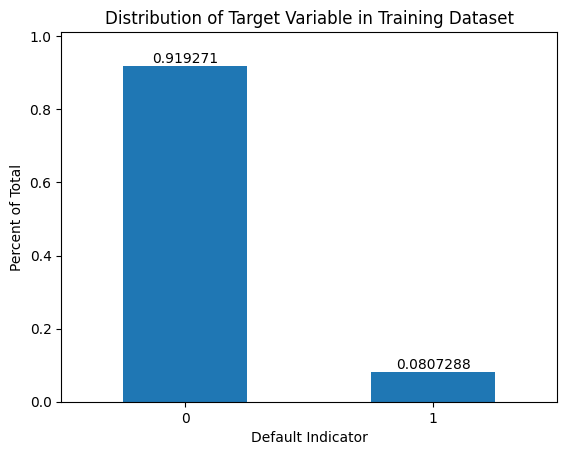

In [58]:
# Plot the distribution of the Response Variable in the training dataset
# Will need to do some form of undersampling or oversampling to deal with the class imbalance

ax = (d['application_train_df']['target'].value_counts()/len(d['application_train_df'])).plot(kind = 'bar')

plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Default Indicator')
plt.ylabel('Percent of Total')
plt.xticks(rotation = 'horizontal')
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.margins(y = 0.1)
plt.show()

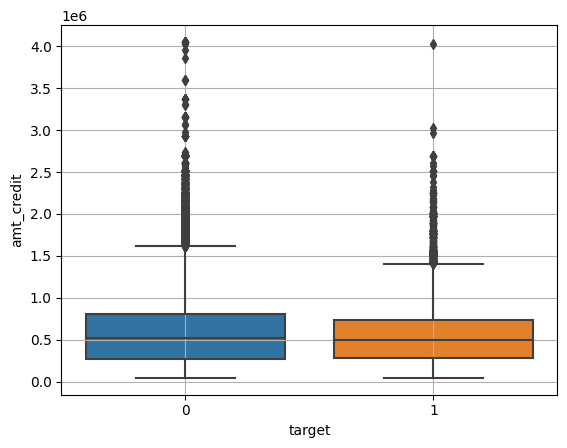

In [64]:
# Does a large amount of credit result in a default condition?  No!

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'amt_credit')
plt.grid()
plt.show()

In [85]:
# Do males default more than females?  Yes!

gender_target_counts = d['application_train_df'].groupby(['code_gender', 'target']).size()

gender_target_counts_unstacked = gender_target_counts.unstack('target')

percentage_defaults_by_gender = gender_target_counts_unstacked.div(gender_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#Changing gender to a binary variable with 1 = Female, 0 Otherwise
d['application_train_df']['code_gender']  = np.where(d['application_train_df']['code_gender'] == 'F',1,0)

target                0          1
code_gender                       
F             93.000672   6.999328
M             89.858080  10.141920
XNA          100.000000        NaN


In [86]:
# Do borrowers who own a car default more than those who do not?  Car owners are less likely to default

own_car_target_counts = d['application_train_df'].groupby(['flag_own_car', 'target']).size()

own_car_target_counts_unstacked = own_car_target_counts.unstack('target')

percentage_defaults_by_gender = own_car_target_counts_unstacked.div(own_car_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

target                0         1
flag_own_car                     
N             91.499773  8.500227
Y             92.756270  7.243730


In [87]:
# Do borrowers who own a realty default more than those who do not?  Approximately equal, but home owners are slightly less likely to default

own_realty_target_counts = d['application_train_df'].groupby(['flag_own_realty', 'target']).size()

own_realty_target_counts_unstacked = own_realty_target_counts.unstack('target')

percentage_defaults_by_gender = own_realty_target_counts_unstacked.div(own_realty_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

target                   0         1
flag_own_realty                     
N                91.675071  8.324929
Y                92.038423  7.961577


In [88]:
# Does the number of children impact default rates?  Approximately equal between 1-2 children, then seemingly impacted between 3-6 children. No children has the lowest default rate.

cnt_children_target_counts = d['application_train_df'].groupby(['cnt_children', 'target']).size()

cnt_children_target_counts_unstacked = cnt_children_target_counts.unstack('target')

percentage_defaults_by_gender = cnt_children_target_counts_unstacked.div(cnt_children_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#convert into 2 binary variables, one for having one child, one for having multiple children. People with multiple children will have a 1 in both columns
d['application_train_df']['has_child']  = np.where(d['application_train_df']['cnt_children'] > 0,1,0)
d['application_train_df']['has_multiple_children']  = np.where(d['application_train_df']['cnt_children'] > 1,1,0)
d['application_train_df'].drop('cnt_children',axis=1,inplace=True)

target                 0           1
cnt_children                        
0              92.288191    7.711809
1              91.076425    8.923575
2              91.278179    8.721821
3              90.368577    9.631423
4              87.179487   12.820513
5              91.666667    8.333333
6              71.428571   28.571429
7             100.000000         NaN
8             100.000000         NaN
9                    NaN  100.000000
10            100.000000         NaN
11                   NaN  100.000000
12            100.000000         NaN
14            100.000000         NaN
19            100.000000         NaN


In [84]:
d['application_train_df'].head(10)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

(0.0, 40.0)

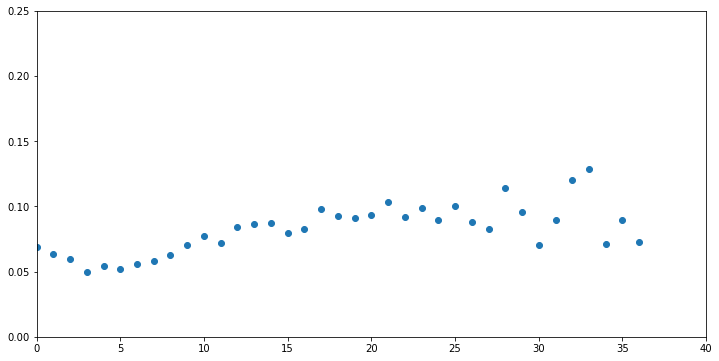

In [44]:
#Age of Car -- Correlated with default, but with the range of values, it may be better to take the log of this value 
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,40)

(0.0, 5.0)

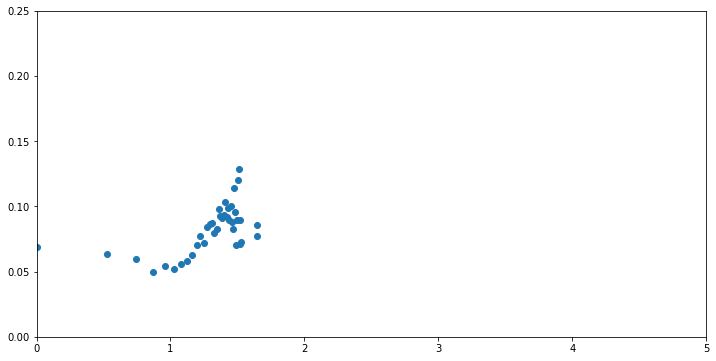

In [46]:
#car age is correlated, so let's just take the log of it, adding 1 to avoid -inf
d['application_train_df']['own_car_age'] = np.log(d['application_train_df']['own_car_age'] + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,5)

In [49]:
#funny enough, there does seem to be some correlation with hour of application
def hour_of_application(hour):
    if hour > 20 or hour < 4:
        return 'night'
    elif hour <= 8:
        return 'morning'
    else:
        return 'day'

In [51]:
d['application_train_df']['hour_appr_process_start'] = d['application_train_df']['hour_appr_process_start'].apply(hour_of_application)

(0.0, 0.1)

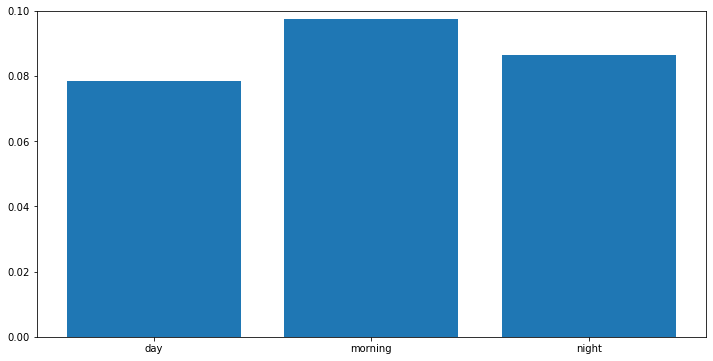

In [53]:
#There may be a correlation with when people start their application
col = 'hour_appr_process_start'
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].index, height = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].values)

ax.set_ylim(0,0.1)

In [ ]:
variables_to_dummy = ['name_income_type','name_education_type','name_family_status','name_housing_type','occupation_type','hour_appr_process_start','organization_type']
potential_variables_to_delete = ['hour_appr_process_start']
confirmed_variables_to_delete = ['weekday_appr_process_start']

In [42]:
#temp = 

#temp.loc[temp['count'] > 100]

own_car_age
0.0     0.068885
1.0     0.063636
2.0     0.059979
3.0     0.049922
4.0     0.053986
5.0     0.051739
6.0     0.055782
7.0     0.058324
8.0     0.063020
9.0     0.070518
10.0    0.076987
11.0    0.072098
12.0    0.084097
13.0    0.086509
14.0    0.087288
15.0    0.079888
16.0    0.082861
17.0    0.097965
18.0    0.092639
19.0    0.091202
20.0    0.093648
21.0    0.103283
22.0    0.092000
23.0    0.098407
24.0    0.089565
25.0    0.100578
26.0    0.087931
27.0    0.082816
28.0    0.114391
29.0    0.095718
30.0    0.070552
31.0    0.089888
32.0    0.120192
33.0    0.128788
34.0    0.071038
35.0    0.089172
36.0    0.072581
64.0    0.085960
65.0    0.077441
Name: mean, dtype: float64

In [31]:
d['application_train_df']['own_car_age'] = np.exp(d['application_train_df']['own_car_age']) - 1

In [27]:
temp

own_car_age
0.000000    0.068885
0.693147    0.063636
1.098612    0.059979
1.386294    0.049922
1.609438    0.053986
              ...   
4.158883    0.000000
4.174387    0.085960
4.189655    0.077441
4.248495    0.000000
4.521789    0.500000
Name: target, Length: 62, dtype: float64

In [ ]:
#filling NA occupation type as Unknown as this will be a dummy variable
d['application_train_df']['occupation_type'].fillna('Unknown',inplace=True)